# EDA on 2010 Medicare Beneficiary Summary

This notebook explores cost and chronic condition patterns in synthetic Medicare data from 2010. The goal is to identify trends and potential high-impact patient profiles.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt


## Load 2010 Beneficiary Data

In [2]:
df = pd.read_csv("../data/raw/synpuf_sample1/DE1_0_2010_Beneficiary_Summary_File_Sample_1.csv")


## Calculate Total Reimbursement Cost
Sum inpatient, outpatient, and carrier reimbursements into a single column.


In [3]:
df["TOTAL_COST"] = df["MEDREIMB_IP"] + df["MEDREIMB_OP"] + df["MEDREIMB_CAR"]


## Distribution of Total Cost per Patient


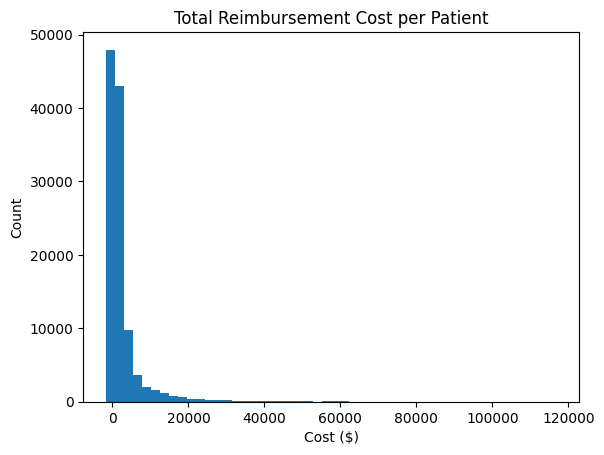

In [4]:
plt.hist(df["TOTAL_COST"], bins=50)
plt.title("Total Reimbursement Cost per Patient")
plt.xlabel("Cost ($)")
plt.ylabel("Count")
plt.show()


## Filter Patients in the Top 10% of Total Cost


In [5]:
high_cost_cutoff = df["TOTAL_COST"].quantile(0.9)
high_cost_df = df[df["TOTAL_COST"] >= high_cost_cutoff]
print(f"High-cost patients: {len(high_cost_df)}")


High-cost patients: 11289


## Count Chronic Conditions per Patient
Each chronic condition is a binary flag. We sum them to get a total burden score.


In [6]:
chronic_cols = [col for col in df.columns if col.startswith("SP_")]
df_chronic = df[["DESYNPUF_ID", "TOTAL_COST"] + chronic_cols]
df_chronic["CHRONIC_COUNT"] = df_chronic[chronic_cols].sum(axis=1)


/var/folders/10/wb_jvbtn56x_z640lnkh9r_m0000gn/T/ipykernel_69407/2640572518.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chronic["CHRONIC_COUNT"] = df_chronic[chronic_cols].sum(axis=1)


## Scatter Plot: Chronic Conditions vs. Total Cost


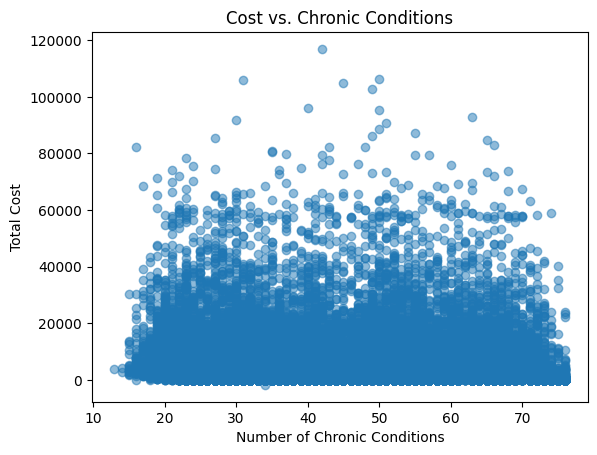

In [7]:
plt.scatter(df_chronic["CHRONIC_COUNT"], df_chronic["TOTAL_COST"], alpha=0.5)
plt.xlabel("Number of Chronic Conditions")
plt.ylabel("Total Cost")
plt.title("Cost vs. Chronic Conditions")
plt.show()


## Create Heuristic-Based Scoring
A simple score to surface interesting patient profiles based on cost and chronic indicators.


In [8]:
def heuristic_score(row):
    score = 0
    if row["TOTAL_COST"] > high_cost_cutoff:
        score += 2
    if row["CHRONIC_COUNT"] >= 3:
        score += 2
    if row["SP_DIABETES"] == 1 or row["SP_CHF"] == 1:
        score += 1
    return score

df_chronic["SCORE"] = df_chronic.apply(heuristic_score, axis=1)


/var/folders/10/wb_jvbtn56x_z640lnkh9r_m0000gn/T/ipykernel_69407/2765255020.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chronic["SCORE"] = df_chronic.apply(heuristic_score, axis=1)


## Preview Top-Scoring Profiles


In [9]:
df_candidates = df_chronic[df_chronic["SCORE"] >= 4]
print(f"Flagged rows: {len(df_candidates)}")
df_candidates.head()


Flagged rows: 11270


,DESYNPUF_ID,TOTAL_COST,SP_STATE_CODE,SP_ALZHDMTA,SP_CHF,SP_CHRNKIDN,SP_CNCR,SP_COPD,SP_DEPRESSN,SP_DIABETES,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,CHRONIC_COUNT,SCORE
1,00016F745862898F,16930.0,39,1,1,1,2,2,2,1,2,2,2,2,57,5
16,0007F12A492FD25D,55720.0,34,2,1,1,2,1,1,1,1,2,2,2,50,5
42,00196F0702489342,18530.0,49,1,1,1,2,2,1,1,1,2,1,1,63,5
65,0021D4CDAFC0609F,7470.0,33,1,1,1,2,2,1,1,2,2,2,2,50,5
69,002354398A00234E,13900.0,5,2,2,2,2,2,2,1,2,2,2,2,26,5


## Save Selected Profiles


In [10]:
df_candidates.to_csv("../data/ai_opportunity_candidates.csv", index=False)
